# 2. Data Analysis

## 1) Extracting parameter values from image files.
- Create a dataframe
- Store as csv file

In [2]:
import cv2
import numpy as np
import mediapipe as mp
import math
import pandas as pd
import glob

# Euclaidean distance for mouse
def euclaideanDistance(point1, point2):
    x1, y1 = point1
    x2, y2 = point2
    distance = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    return distance

data = {
    'lx': [],  # Left eye iris x-coordinate
    'ly': [],  # Left eye iris y-coordinate
    'lh': [],  # Left eye height
    'lw': [],  # Left eye width
    'rx': [],  # Right eye iris x-coordinate
    'ry': [],  # Right eye iris y-coordinate
    'rh': [],  # Right eye height
    'rw': [],  # Right eye width
    'U_D': [], # 0: Up, 1: Middle, 2: Down
    'L_R': []  # 0: Left, 1: Middle, 2: Right
}
df = pd.DataFrame(data)
df.index.name = 'Index'



# Open the data file
image_path = 'Face/*.jpg'
image_files = glob.glob(image_path) # Counthing the number of image files
total_images = len(image_files)
idx = 0

with mp.solutions.face_mesh.FaceMesh(
    max_num_faces = 1,
    refine_landmarks = True, # refine landmarks 468 to 478
    min_detection_confidence = 0.5,
    min_tracking_confidence = 0.5
) as face_mesh:
    for idx in range(total_images):
        # Reading the image
        image = cv2.imread('Face/{}_img.jpg'.format(idx))

        rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = face_mesh.process(rgb_image)
        if results.multi_face_landmarks:
            h, w = image.shape[:2]
            # Landmarks Detection
            mesh_coords = np.array([(point.x, point.y) for point in results.multi_face_landmarks[0].landmark])
            
            # Calculating the coordinates of the center for each eye
            # Defining the center of the eyes as the average of the left & right endpoints
            L_center = (mesh_coords[33] + mesh_coords[133])/2
            R_center = (mesh_coords[362] + mesh_coords[263])/2
            
            # Calculating the distance and direction of the iris from the center of the eye
            # Detecting the downward direction of the iris is challenging
            LCen2Iris_x, LCen2Iris_y = mesh_coords[468] - L_center
            RCen2Iris_x, RCen2Iris_y = mesh_coords[473] - R_center
            
            # Measuring the height and width of each eye
            # Height : Intended for detecting the downward direction
            #          Detecting the upward direction is challenging
            # Width : As the distance increases, the value decreases
            #         For correction of the error that occurs in this case
            #
            # Blink detection using the EAR method is possible with these values
            L_height = euclaideanDistance(mesh_coords[159], mesh_coords[145])
            L_width = euclaideanDistance(mesh_coords[33], mesh_coords[133])
             
            R_height = euclaideanDistance(mesh_coords[386], mesh_coords[374])
            R_width = euclaideanDistance(mesh_coords[362], mesh_coords[263])
            
            # Determining the gaze directions
            u_d = (idx%9)//3
            l_r = (idx%9)%3
            
            # Storing the obtained parameters in a data frame
            df.loc[idx] = [LCen2Iris_x, LCen2Iris_y, L_height, L_width, RCen2Iris_x, RCen2Iris_y, R_height, R_width, u_d, l_r]

df.to_csv('gaze_data.csv')
df

,lx,ly,lh,lw,rx,ry,rh,rw,U_D,L_R
Index,,,,,,,,,,


## 2) Designing the process based on the collected data
- Taking a weighted sum of the inputs to extract the output values for x and y
- Adjusting the values of 'w' and 'b' according to the scatter plot
  1. w : Maintaining a consistent spacing between the markers
  2. b : Aligning the center value to (0, 0)

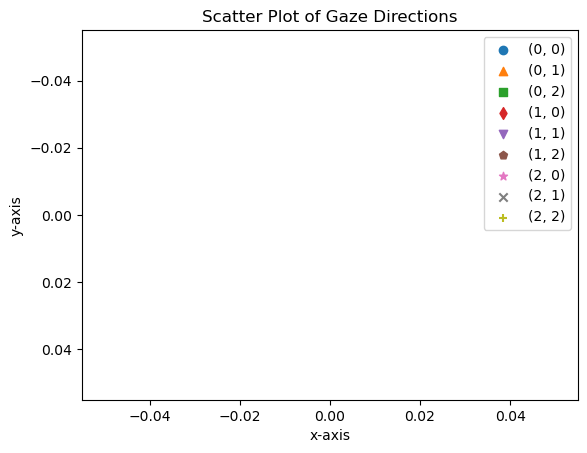

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('gaze_data.csv', index_col = 'Index')

# Create a dictionary of marker styles for each U_D and L_R group
#
# Gaze Directions
# ----------------------------
# | (0, 0) | (0, 1) | (0, 2) |
# ----------------------------
# | (1, 0) | (1, 1) | (1, 2) |
# ----------------------------
# | (2, 0) | (2, 1) | (2, 2) |
# ----------------------------
markers = {
    (0, 0): 'o',
    (0, 1): '^',
    (0, 2): 's',
    (1, 0): 'd',
    (1, 1): 'v',
    (1, 2): 'p',
    (2, 0): '*',
    (2, 1): 'x',
    (2, 2): '+'
}

# Weight Sum & Bias
# Adjusting the values of 'w' and 'b' according to the scatter plot
W = 0.2
B = 0.13

# Create a scatter plot with different gaze directions
for group, marker in markers.items():
    ud, lr = group
    df_group = df[(df['U_D'] == ud) & (df['L_R'] == lr)]
    
    # When the face rotates, the size of one eye becomes smaller 
    # It makes it difficult to trust the information coming from that eye
    L_weight = df_group['lw']/(df_group['lw']+df_group['rw'])
    R_weight = df_group['rw']/(df_group['lw']+df_group['rw'])
    
    # By dividing the corresponding variable, error correction based on distance is performed            
    # As the distance between the screen and the face increases, all parameter values decrease
    # Select the larger value between the widths of the eyes
    distance_correction = df_group['lw'].where(df_group['lw'] > df_group['rw'], df_group['rw'])
    
    x_axis = (L_weight*df_group['lx']+R_weight*df_group['rx'])/distance_correction
    y_axis = (L_weight*df_group['ly']+R_weight*df_group['ry']
             - W*(L_weight*df_group['lh']+R_weight*df_group['rh']))/distance_correction + B
    plt.scatter(x_axis, y_axis,marker=marker, label=f'({ud}, {lr})')

# Add a title, axis labels, and legend
plt.title('Scatter Plot of Gaze Directions')
plt.xlabel('x-axis')
plt.ylabel('y-axis')

# Invert y-axis
plt.gca().invert_yaxis()

plt.legend()

# Show the plot
plt.show()